# Modeling Workflow Example - Greenplum Database

----

Greenplum Database features used

* Apache MADlib - http://madlib.apache.org/
* Procedural language extension to Python - https://gpdb.docs.pivotal.io/530/ref_guide/extensions/pl_python.html

----

### Example Description

**Use case:**

Using available credit card application data build a classification model to predict whether or not a new application will be approved.

**Data:** 

Credit Approval Data Set found at UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/Credit+Approval

----

## Index

### Setup 

* <a href="#dependencies">Dependencies</a>
* <a href="#package_options">Package Options</a>
* <a href="#database_connection">Database Connection</a>
    
    
### Data Loading

* <a href="#external_table">External Table Definition</a>
* <a href="#download_data">Download Data</a>
* <a href="#view_sample">View Sample</a>


### Data Audit

* <a href="#summary_statistics">Summary Statistics</a>


### Data Exploration

* <a href="#de_categorical">Categorical Columns</a>
* <a href="#de_continuous">Continuous Columns</a>


### Feature Engineering

* <a href="#fe_continuous">Continuous Features</a>
* <a href="#fe_one_hot">One Hot Encode Categorical Features</a>
* <a href="#fe_combine">Combine Continuous & Categorical Features</a>
* <a href="#fe_cats_dep">Plot Categorical Features By Response</a>
* <a href="#fe_chi_sq">Chi-squared Testing</a>
* <a href="#fe_corr">Correlation Testing</a>
* <a href="#fe_scatter">Scatter Plots</a>


### Model Development

* <a href="#train_vali_split">Training & Validation Sample Split</a>


* **Random Forest**
    * <a href="#rf_train_model">Train model</a>
    * <a href="#rf_variable_importance">Variable Importance</a>
    * <a href="#rf_score_out_of_sample">Score Validation Data</a>
    * <a href="#rf_auc">Area Under ROC Curve</a>
    * <a href="#rf_roc">Receiver Operating Characteristic Graph (ROC Curve)</a>
    * <a href="#rf_confusion_matrix">Confusion Matrix</a>
    * <a href="#rf_plpythonexample">PL/Python Example</a>

----


----
## Setup

<a id="dependencies"></a>

In [215]:
# dependencies
import psycopg2               # Python-PostgreSQL Database Adapter - https://pypi.python.org/pypi/psycopg2
import pandas as pd           # Python Data Analysis Library - https://pandas.pydata.org/
import seaborn as sns         # Statistical data visualization - https://seaborn.pydata.org/
import math                   # Mathematical functions - https://docs.python.org/2/library/math.html
import textwrap as tw         # Text wrapping and filling - https://docs.python.org/2/library/textwrap.html
import ipywidgets as widgets  # Jupyter Widgets - https://ipywidgets.readthedocs.io/en/latest/
import IPython.display as ipd # http://ipython.org/documentation.html

<a id="package_options"></a>

In [216]:
# package options
# %matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (12, 8)
    
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', -1)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


/root/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<a id="database_connection"></a>

In [217]:
# init to default values
database_host = 'gpdb'
database_databasename = 'gpadmin'
database_username = 'gpadmin'
database_password = 'pivotal'

# interpret string as markdown
def printmd(string):
    ipd.display(ipd.Markdown(string))
    
# forms
message = "### Connection Details \n ------"
printmd(message)
    
printmd("**Host:**")
inputHost = widgets.Text()
ipd.display(inputHost)

printmd("**Database Name:**")
inputDatabaseName = widgets.Text()
ipd.display(inputDatabaseName)

printmd("**Username:**")
inputUsername = widgets.Text()
ipd.display(inputUsername)

printmd("**Password:**")
inputPassword = widgets.Text()
ipd.display(inputPassword)

printmd("*Leave blank for default values*")


def db_connect():
    global conn, cur
    try:
        conn = psycopg2.connect("host='{}' dbname='{}' user='{}' password='{}'".format(database_host,database_databasename,database_username,database_password))
        cur = conn.cursor()
        conn.autocommit = True
        message = "<span style='color:green'>**Connection successful!**</span>"
        printmd(message)
    except:
        message = "<span style='color:red'>**ERROR: Unable to connect to the database**</span>"
        printmd(message)
    
def on_button_click(b):
    
    global database_host, database_databasename, database_username, database_password
    
    ipd.clear_output()
    
    message = "### Connection Details \n ------"
    printmd(message)
    
    if inputHost.value == "":
        message = "**Host:** {} (default)".format(database_host)
        printmd(message)
    else:
        database_host = inputHost.value
        message = "**Host:** {}".format(database_host)
        printmd(message)
  
    if inputDatabaseName.value == "":
        message = "**Database name:** {} (default)".format(database_databasename)
        printmd(message)
    else:
        database_databasename = inputDatabaseName.value
        message = "**Database name:** {}".format(database_databasename)
        printmd(message)
        
    if inputUsername.value == "":
        message = "**Username:** {} (default)".format(database_username)
        printmd(message)
    else:
        database_username = inputUsername.value
        message = "**Username:** {}".format(database_username)
        printmd(message)
        
    if inputPassword.value == "":
        message = "**Password:** {} (default)".format(database_password)
        printmd(message)
    else:
        database_password = inputPassword.value
        message = "**Password:** ###########"
        printmd(message)
    
    printmd("------")
    db_connect()
        
button = widgets.Button(description="Connect")
ipd.display(button)
button.on_click(on_button_click)

### Connection Details 
 ------

**Host:** gpdb (default)

**Database name:** gpadmin (default)

**Username:** gpadmin (default)

**Password:** pivotal (default)

------

<span style='color:green'>**Connection successful!**</span>

----
## Data Loading

<a id="external_table"></a>

In [60]:
# create external web table
ddl = """
    DROP EXTERNAL TABLE IF EXISTS public.credit_application_external;
    CREATE EXTERNAL WEB TABLE public.credit_application_external (
        a1 varchar(1)
       ,a2 float
       ,a3 float
       ,a4 varchar(1)
       ,a5 varchar(2)
       ,a6 varchar(2)
       ,a7 varchar(2)
       ,a8 float
       ,a9 boolean
       ,a10 boolean
       ,a11 float
       ,a12 boolean
       ,a13 varchar(1)
       ,a14 float
       ,a15 float
       ,a16 varchar(1)
    ) LOCATION ('http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data')
    FORMAT 'CSV'
    (NULL AS '?');
"""
cur.execute(ddl)

<a id="download_data"></a>

In [61]:
# impute mean or most freq occuring value for null 
query = """
    DROP TABLE IF EXISTS public.credit_application_data;
    CREATE TABLE public.credit_application_data AS
    SELECT row_number() OVER() AS _id
          ,coalesce(a1,'b') AS a1
          ,coalesce(a2, avg(a2) OVER()) AS a2
          ,coalesce(a3, avg(a3) OVER()) AS a3
          ,coalesce(a4, 'u') AS a4
          ,coalesce(a5, 'g') AS a5
          ,coalesce(a6, 'c') AS a6
          ,coalesce(a7, 'v') AS a7
          ,coalesce(a8, avg(a8) OVER()) AS a8
          ,coalesce(a9, True) AS a9
          ,coalesce(a10, False) AS a10
          ,coalesce(a11, 0) AS a11
          ,coalesce(a12, False) AS a12
          ,coalesce(a13, 'g') AS a13
          ,coalesce(a14, avg(a14) OVER()) AS a14
          ,coalesce(a15, avg(a15) OVER()) AS a15
          ,CASE WHEN a16 = '+' THEN 1 ELSE 0 END AS a16
    FROM public.credit_application_external
    DISTRIBUTED RANDOMLY;
"""
cur.execute(query)

<a id="view_sample"></a>

In [89]:
# helper function
def query_gpdb(query): 

    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

In [90]:
# view sample
query = """
    SELECT *
    FROM public.credit_application_data
    LIMIT 5
"""
query_gpdb(query)

,_id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
0,1,b,30.83,0.000,u,g,w,v,1.25,True,True,1.0,False,g,202.0,0.0,1
1,3,a,24.50,0.500,u,g,q,h,1.50,True,False,0.0,False,g,280.0,824.0,1
2,5,b,20.17,5.625,u,g,w,v,1.71,True,False,0.0,False,s,120.0,0.0,1
3,7,b,33.17,1.040,u,g,r,h,6.50,True,False,0.0,True,g,164.0,31285.0,1
4,9,b,54.42,0.500,y,p,k,h,3.96,True,False,0.0,False,g,180.0,314.0,1


----
## Data Audit

<a id="summary_statistics"></a>
Summary Statistics

In [91]:
# drop existing table & run madlib summary stats function
query = """
    DROP TABLE IF EXISTS public.credit_application_summary;
    SELECT madlib.summary('public.credit_application_data','public.credit_application_summary');
"""
cur.execute(query)

# grab results from gpdb
query = """
    SELECT * FROM public.credit_application_summary;
"""
data_summary = query_gpdb(query)

In [92]:
data_summary

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,_id,1,int8,690,690,0,NaN,0.0,NaN,345.500000,3.973250e+04,1.00,690.00,173.250,345.500,517.7500,"[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,None,None,a1,2,varchar,690,2,0,0.0,0.0,0.0,NaN,NaN,1.00,1.00,NaN,NaN,NaN,"[b, b, a, a]","[480, 480, 210, 210]"
2,None,None,a2,3,float8,690,350,0,NaN,0.0,NaN,31.568171,1.405001e+02,13.75,80.25,22.670,28.625,37.7075,"[31.5681710914455, 31.5681710914455, 22.67, 20.42, 19.17, 25, 18.83, 23.58, 24.5, 20.67]","[12, 12, 9, 7, 6, 6, 6, 6, 6, 6]"
3,None,None,a3,4,float8,690,215,0,NaN,0.0,NaN,4.758725,2.478211e+01,0.00,28.00,1.000,2.750,7.2075,"[1.5, 1.5, 2.5, 3, 0, 2.5, 0, 3, 1.25, 0.75]","[21, 21, 19, 19, 19, 19, 19, 19, 16, 16]"
4,None,None,a4,5,varchar,690,3,0,0.0,0.0,0.0,NaN,NaN,1.00,1.00,NaN,NaN,NaN,"[u, u, y, y, l]","[525, 525, 163, 163, 2]"
5,None,None,a5,6,varchar,690,3,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[g, g, p, p, gg]","[525, 525, 163, 163, 2]"
6,None,None,a6,7,varchar,690,14,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[c, c, q, q, w, w, i, i, aa, aa]","[146, 146, 78, 78, 64, 64, 59, 59, 54, 54]"
7,None,None,a7,8,varchar,690,9,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[v, v, h, h, bb, bb, ff, ff, j, z]","[408, 408, 138, 138, 59, 59, 57, 57, 8, 8]"
8,None,None,a8,9,float8,690,132,0,NaN,0.0,NaN,2.223406,1.119915e+01,0.00,28.50,0.165,1.000,2.6250,"[0, 0, 0.25, 0.25, 0.04, 0.04, 1, 1, 0.125, 0.125]","[70, 70, 35, 35, 33, 33, 31, 31, 30, 30]"
9,None,None,a9,10,bool,690,2,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[t, t, f, f]","[361, 361, 329, 329]"


----
## Data Exploration

<a id="de_categorical"></a>
#### Categorical Columns

-----
 **Select Column:**

A Jupyter Widget

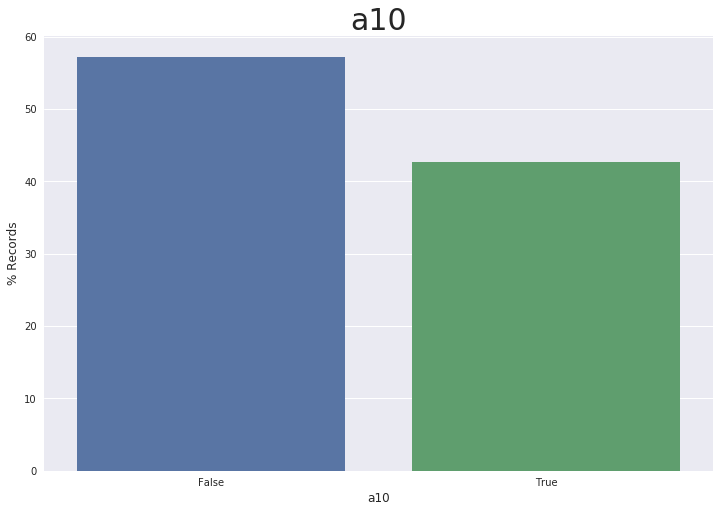

In [218]:
catColumns = ['a1','a4','a5','a6','a7','a9','a10','a12','a13','a16']

def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=12)
    plt.set_ylabel(yLabel,fontsize=12)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')


def get_cat_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,count(*) AS record_count
            FROM public.credit_application_data
            GROUP BY 1
        ) foo
        ORDER BY perc_records DESC
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catDropdown)
        df = get_cat_data_frame(res['new'])
        bar_plot(df,res['new'],"col",res['new'],"perc_records","% Records", None, 0)
    
catDropdown = widgets.Dropdown(
    options=catColumns,
    value=catColumns[0],
    description='Column:',
    disabled=False,
)

catDropdown.observe(on_cat_selection)
printmd("-----\n **Select Column:**")
ipd.display(catDropdown)
df = get_cat_data_frame(catColumns[0])
bar_plot(df,catColumns[0],"col",catColumns[0],"perc_records","% Records", None, 0)

<a id="de_continuous"></a>
#### Continuous Columns

-----
 **Select Column:**

A Jupyter Widget

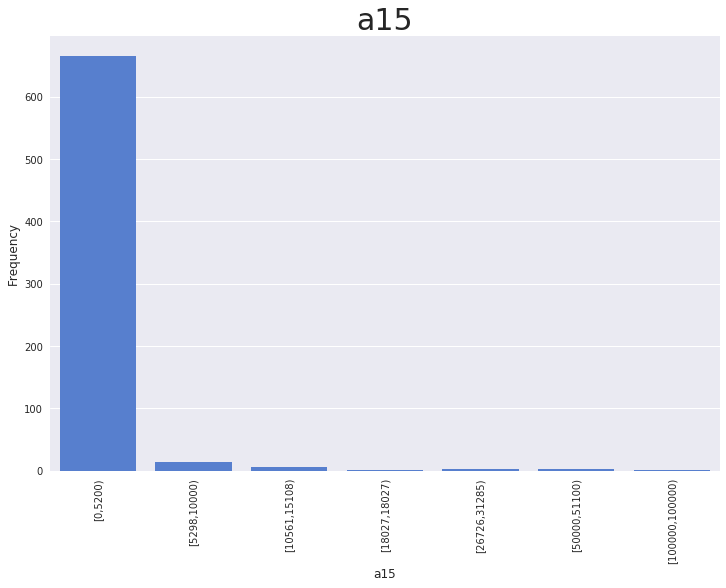

In [219]:
contColumns = ['a2','a3','a8','a11','a14','a15']

def get_cont_data_frame(col):
    query = """
        WITH aggs AS (
            SELECT min({c}) AS min,
                   max({c}) AS max
              FROM public.credit_application_data
        )
        SELECT width_bucket({c}, min, max, 19) AS bucket,
               ('[' || min({c}) || ',' || max({c}) || ')')::text as range,
               count(*) as freq
        FROM public.credit_application_data, aggs
        GROUP BY bucket
        ORDER BY bucket
    """.format(c=col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cont_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(contDropdown)
        df = get_cont_data_frame(res['new'])
        bar_plot(df,res['new'],"range",res['new'],"freq","Frequency", "#4378E2")
        
# Look at log transforms
# colsAddLogs = contColumns + ["log({} + 1)".format(c) for c in contColumns]
colsAddLogs = contColumns

contDropdown = widgets.Dropdown(
    options=colsAddLogs,
    value=colsAddLogs[0],
    description='Column:',
    disabled=False,
)

contDropdown.observe(on_cont_selection)
printmd("-----\n **Select Column:**")
ipd.display(contDropdown)
df = get_cont_data_frame(contColumns[0])
bar_plot(df,contColumns[0],"range",contColumns[0],"freq","Frequency", "#4378E2")



*Note - Consider variable transformation if test non-tree based algorithm.*

----
## Feature Engineering

<a id="fe_continuous"></a>
#### Continuous Features

In [220]:
# continuos features (seperated out incase feature transformations are required)
query = """
    DROP TABLE IF EXISTS public.model_inputs_cont;
    CREATE TABLE public.model_inputs_cont AS
    SELECT _id
          ,a16 AS approval
          ,a2
          ,a3
          ,a8
          ,a11
          ,a14
          ,a15
    FROM public.credit_application_data
    DISTRIBUTED BY (_id);
    SELECT * FROM public.model_inputs_cont LIMIT 0;
"""
cur.execute(query)

contFeatureNames = [desc[0] for desc in cur.description]
contFeatureNames.remove('_id')
contFeatureNames.remove('approval')

query = """
    SELECT *
    FROM public.model_inputs_cont
"""
df = query_gpdb(query)

print len(df)

df.head()

690


,_id,approval,a2,a3,a8,a11,a14,a15
0,1,1,30.83,0.000,1.25,1.0,202.0,0.0
1,3,1,24.50,0.500,1.50,0.0,280.0,824.0
2,5,1,20.17,5.625,1.71,0.0,120.0,0.0
3,7,1,33.17,1.040,6.50,0.0,164.0,31285.0
4,9,1,54.42,0.500,3.96,0.0,180.0,314.0


<a id="fe_one_hot"></a>
#### One Hot Encode Categorical Features

In [221]:
# encode categorical features
# https://madlib.apache.org/docs/latest/group__grp__encode__categorical.html
query = """
    DROP TABLE IF EXISTS public.model_inputs_cat;
    SELECT madlib.encode_categorical_variables (
        'public.credit_application_data',
        'public.model_inputs_cat',
        'a1,a4,a5,a6,a7,a9,a10,a12,a13',
        NULL,
        '_id',
        NULL,
        'a1=b, a4=y, a5=p, a6=x, a7=z, a9=False, a10=False, a12=False, a13=s'
    );
"""
cur.execute(query)

query = """
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a9_True" TO a9_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a10_True" TO a10_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a12_True" TO a12_true;
"""
cur.execute(query)

query = """
    SELECT *
    FROM public.model_inputs_cat
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

colnames.remove('_id')
catFeatureNames = colnames
featureNames = contFeatureNames + catFeatureNames
print featureNames
df.head()

['a2', 'a3', 'a8', 'a11', 'a14', 'a15', 'a1_a', 'a4_l', 'a4_u', 'a5_g', 'a5_gg', 'a6_aa', 'a6_c', 'a6_cc', 'a6_d', 'a6_e', 'a6_ff', 'a6_i', 'a6_j', 'a6_k', 'a6_m', 'a6_q', 'a6_r', 'a6_w', 'a7_bb', 'a7_dd', 'a7_ff', 'a7_h', 'a7_j', 'a7_n', 'a7_o', 'a7_v', 'a9_true', 'a10_true', 'a12_true', 'a13_g', 'a13_p']


,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p
0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0
1,3,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
2,5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
3,7,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0


<a id="fe_combine"></a>
#### Combine Continuous & Categorical Features

In [222]:
# combine feature tables
query = """
    DROP TABLE IF EXISTS public.model_inputs;
    CREATE TABLE public.model_inputs AS
    SELECT *
    FROM public.model_inputs_cat
    JOIN public.model_inputs_cont
    USING (_id);
"""
cur.execute(query)

<a id="fe_cats_dep"></a>
#### Plot Categorical Features By Response

-----
 **Select Column:**

A Jupyter Widget

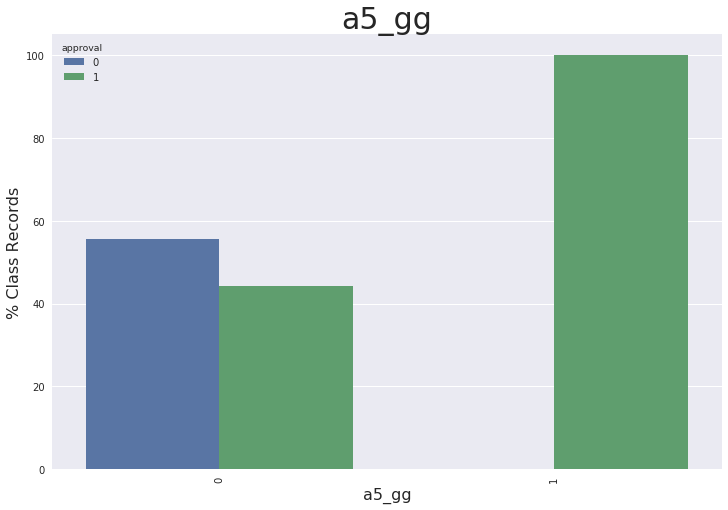

In [223]:
def bar_plot_groupby(data, title,x,xLabel,y,yLabel,groupby,color=None,axisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color, hue=groupby)
    else:
        plt = sns.barplot(x=x, y=y, data=data, hue=groupby)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(axisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')

def get_cat_gb_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(PARTITION BY col),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,approval
                  ,count(*) AS record_count
            FROM public.model_inputs
            GROUP BY 1,2
        ) foo
        ORDER BY 1,2
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_gb_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catGPDropdown)
        df = get_cat_gb_data_frame(res['new'])
        bar_plot_groupby(df,res['new'],"col",res['new'],"perc_records","% Class Records", "approval")
    
catGPDropdown = widgets.Dropdown(
    options=catFeatureNames,
    value=catFeatureNames[0],
    description='Column:',
    disabled=False,
)

catGPDropdown.observe(on_cat_gb_selection)
printmd("-----\n **Select Column:**")
ipd.display(catGPDropdown)
df = get_cat_gb_data_frame(catFeatureNames[0])
bar_plot_groupby(df,catFeatureNames[0],"col",catFeatureNames[0],"perc_records","% Class Records","approval")

<a id="fe_chi_sq"></a>
#### Chi-squared testing

,feature_name,response,statistic,p_value,df,phi,contingency_coef
0,a7_o,approval,0.024633,8.752845e-01,1,0.078475,0.078234
0,a6_c,approval,0.038090,8.452629e-01,1,0.097583,0.097122
0,a7_n,approval,0.049410,8.240931e-01,1,0.111142,0.110462
0,a6_m,approval,0.092817,7.606255e-01,1,0.152330,0.150593
0,a7_bb,approval,0.117396,7.318764e-01,1,0.171315,0.168855
0,a7_j,approval,0.160255,6.889216e-01,1,0.200159,0.196266
0,a7_dd,approval,0.305203,5.806390e-01,1,0.276226,0.266255
0,a1_a,approval,0.577660,4.472309e-01,1,0.380020,0.355234
0,a6_r,approval,0.599873,4.386265e-01,1,0.387257,0.361124
0,a12_true,approval,0.690089,4.061341e-01,1,0.415358,0.383585


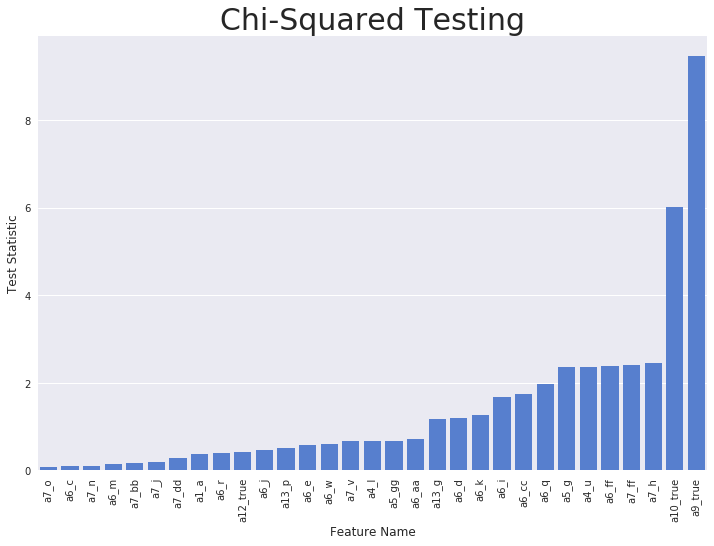

In [224]:
def chi2_gof_test(feature_name, response):
    query = """
        WITH freq AS (
            SELECT {feature_name}
                  ,{response}
                  ,count(*) AS observed
            FROM public.model_inputs
            GROUP BY 1,2
        )
        SELECT '{feature_name}' AS feature_name
              ,'{response}' AS response
              ,(madlib.chi2_gof_test(observed, expected, deg_freedom)).*
        FROM (
            SELECT observed
                  ,sum(observed) OVER (PARTITION BY {feature_name})::DOUBLE PRECISION
                       * sum(observed) OVER (PARTITION BY {response}) AS expected
            FROM freq
        ) l, (
            SELECT (count(distinct {feature_name}) - 1) * (count(distinct {response}) - 1) AS deg_freedom
            FROM freq
        ) r;
    """.format(feature_name=feature_name, response=response)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

def chi2_gof_test_multi(feature_list, response):
    res = chi2_gof_test(feature_list[0], response)
    for i in range(1,len(feature_list)):
        res = res.append(chi2_gof_test(feature_list[i], response))
        
    return res

chi2_results = chi2_gof_test_multi(catFeatureNames, 'approval')
chi2_results.sort_values('phi', inplace=True)
ipd.display(chi2_results)
bar_plot(chi2_results, "Chi-Squared Testing","feature_name","Feature Name","phi","Test Statistic", "#4378E2")

<a id="fe_corr"></a>
#### Correlation Testing

In [225]:
# calc correlations
query = """
    DROP TABLE IF EXISTS public.feature_correlations, public.feature_correlations_summary;
    SELECT madlib.correlation( 
        'public.model_inputs',
        'public.feature_correlations',
        '{}'
    );
    SELECT * 
    FROM public.feature_correlations
    ORDER BY column_position;
""".format(",".join(contFeatureNames))
corr = query_gpdb(query)

corr.drop('column_position', 'columns', inplace=True)
corr.set_index('variable', True, False, True)
corr

,a2,a3,a8,a11,a14,a15
variable,,,,,,
a2,1.000000,NaN,NaN,NaN,NaN,NaN
a3,0.201316,1.000000,NaN,NaN,NaN,NaN
a8,0.392787,0.298902,1.000000,NaN,NaN,NaN
a11,0.185575,0.271207,0.322330,1.000000,NaN,NaN
a14,-0.077161,-0.222346,-0.076389,-0.119809,1.000000,NaN
a15,0.018539,0.123121,0.051345,0.063692,0.065609,1.0


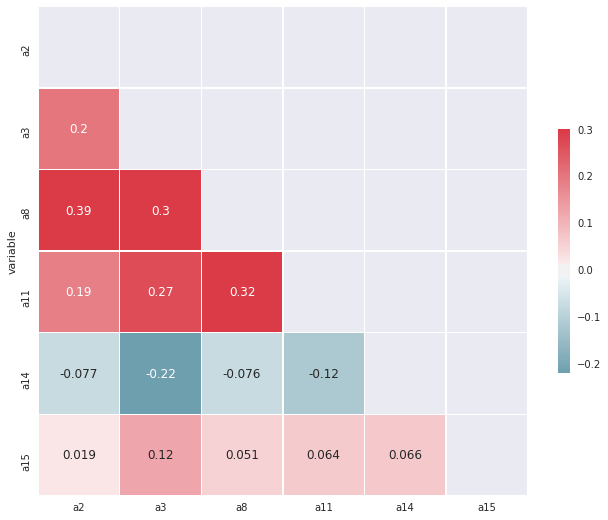

In [226]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<a id="fe_scatter"></a>
#### Scatter Plots

In [227]:
def sample_scatter(title, x, xLabel, y, yLabel, sampleSize):
    
    pylab.rcParams['figure.figsize'] = (8, 8)

    # Grab sample
    query = """
        SELECT count(*) AS n
        FROM public.model_inputs;
    """.format(",".join(contFeatureNames))
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    n = pd.DataFrame(cur.fetchall(), columns=colnames)['n'][0]
    limit = math.floor(n * sampleSize)
    
    query = """
        SELECT {} AS col1
              ,{} AS col2
        FROM public.model_inputs
        LIMIT {};
    """.format(x, y, limit)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    sample = pd.DataFrame(cur.fetchall(), columns=colnames)    
    
    # Generate scatterplot
    if x == y:
        sample
    plt = sns.regplot(x="col1", y="col2", data=sample)
    
    # titles
    plt.set_title("\n".join(tw.wrap(title,50)),fontsize=16)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)

    # add 1000s commas
    plt.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    plt.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

-----
 **Select Features:**

A Jupyter Widget

A Jupyter Widget

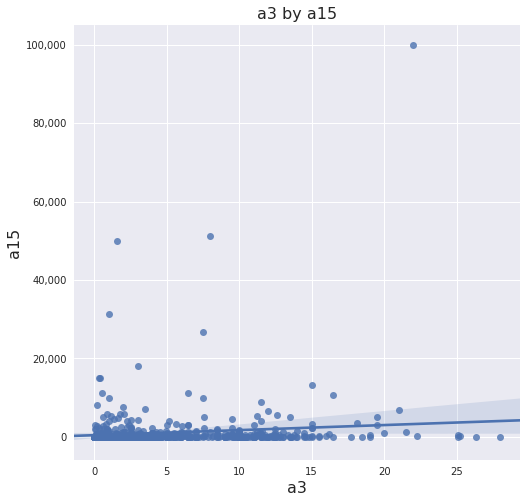

In [228]:
x = contFeatureNames[0]
y = contFeatureNames[1]

def reset():
    ipd.clear_output()
    printmd("-----\n **Select Features:**")
    ipd.display(scatterDropdown1, scatterDropdown2)

    sample_scatter("{} by {}".format(x, y), x, x, y, y, 1)   
    
def os1(res):
    global x
    if res['type'] == 'change' and res['name'] == 'value':
        contFeatureNames.append(x)
        x = res['new']
        contFeatureNames.remove(x)
        reset()

def os2(res):
    global y
    if res['type'] == 'change' and res['name'] == 'value':
        y = res['new']
        reset()
                   
scatterDropdown1 = widgets.Dropdown(
    options=contFeatureNames,
    value=x,
    description='x:',
    disabled=False,
)

scatterDropdown2 = widgets.Dropdown(
    options=contFeatureNames,
    value=y,
    description='y:',
    disabled=False,
)

scatterDropdown1.observe(os1)
scatterDropdown2.observe(os2)

reset()


----
## Model Training

### Random Forest

<a id="train_vali_split"></a>
#### Training & Validation Sample Split

In [229]:
# split training and validation set
# we are careful not to include the same customer in both sets
# https://madlib.apache.org/docs/latest/group__grp__train__test__split.html
query = """
    DROP TABLE IF EXISTS public.model
                        ,public.model_train
                        ,public.model_test;
                        
    SELECT madlib.train_test_split(
        'public.model_inputs',
        'public.model',
        0.7,
        NULL,
        NULL,
        '*',
        FALSE,
        TRUE
    )
"""
cur.execute(query)

In [230]:
query = """
    SELECT *
    FROM public.model_train
    LIMIT 5
"""
df = query_gpdb(query)
df

,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,approval,a2,a3,a8,a11,a14,a15
0,3,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,24.50,0.500,1.50,0.0,280.0,824.0
1,6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,32.08,4.000,2.50,0.0,360.0,0.0
2,14,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,48.08,6.040,0.04,0.0,0.0,2690.0
3,17,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,28.25,0.875,0.96,3.0,396.0,0.0
4,26,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,15.83,0.585,1.50,2.0,100.0,0.0


<a id="rf_train_model"></a>
#### Train model

In [231]:
# traing random forest model
# https://madlib.apache.org/docs/latest/group__grp__random__forest.html

query = """
DROP TABLE IF EXISTS public.rf_model_output, public.rf_model_output_summary, public.rf_model_output_group;
SELECT madlib.forest_train(
            'public.model_train',
            'public.rf_model_output',
            '_id',
            'approval',
            '{}',
            null,
            null,
            10::integer,
            5::integer,
            true::boolean,
            5::integer,
            10::integer,
            3::integer,
            1::integer,
            10::integer
        )
""".format(','.join(featureNames))
cur.execute(query)

In [232]:
# view model summary
query = """
    SELECT *
    FROM public.rf_model_output_summary
"""

df = query_gpdb(query)
df

,method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
0,forest_train,True,public.model_train,public.rf_model_output,_id,approval,"a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,a2,a3,a8,a11,a14,a15","a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p","a2,a3,a8,a11,a14,a15",None,10,5,10,3,1,10,False,True,5,1,0,483,0,"""0"",""1""",integer,"integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, double precision, double precision, double precision, double precision, double precision, double precision",None


<a id="rf_variable_importance"></a>
#### Variable Importance

,type,feature_name,feature_importance
0,cat,a9_true,-0.024190
1,cat,a10_true,-0.084008
2,con,a11,-0.084274
3,con,a8,-0.086036
4,con,a15,-0.095226
5,con,a3,-0.098481
6,cat,a7_h,-0.098855
7,con,a2,-0.099530
8,cat,a4_u,-0.099781
9,cat,a13_g,-0.099930


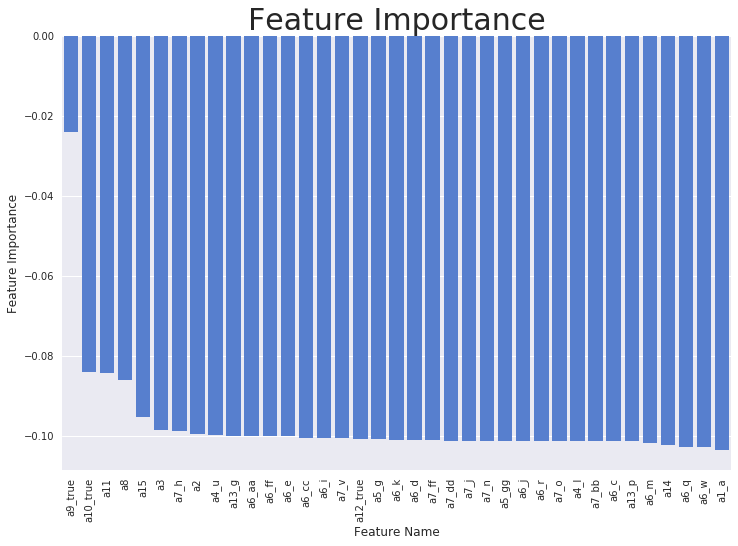

In [233]:
# feature importance
query = """
    SELECT 'cat' AS type
          ,unnest(string_to_array(cat_features,',')) AS feature_name
          ,unnest(cat_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    UNION
    SELECT 'con' AS type
          ,unnest(string_to_array(con_features,',')) AS feature_name
          ,unnest(con_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    ORDER BY 3 DESC
"""

df = query_gpdb(query)
ipd.display(df.head(10))
bar_plot(df,"Feature Importance","feature_name",'Feature Name',"feature_importance","Feature Importance", "#4378E2")

<a id="rf_score_out_of_sample"></a>
#### Score Validation Data

In [234]:
# Score out-of-sample
query = """
    DROP TABLE IF EXISTS public.model_test_scored;
    SELECT madlib.forest_predict('public.rf_model_output',
                                 'public.model_test',
                                 'public.model_test_scored',
                                 'prob');
                
    DROP TABLE IF EXISTS public.model_test_scored_tmp;
    CREATE TABLE public.model_test_scored_tmp AS
    SELECT *
    FROM public.model_test_scored
    JOIN public.model_test
    USING (_id);
    DROP TABLE public.model_test_scored;
    ALTER TABLE public.model_test_scored_tmp RENAME TO model_test_scored;
    SELECT * FROM public.model_test_scored LIMIT 0;
    
"""
cur.execute(query)

<a id="rf_auc"></a>
#### Area Under ROC Curve

In [235]:
# auc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_auc;
    SELECT madlib.area_under_roc(
        'public.model_test_scored'
       ,'public.model_test_scored_auc'
       ,'estimated_prob_1'
       ,'approval'
    )
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_test_scored_auc;
"""
auc = query_gpdb(query)['area_under_roc'][0]

message = """-----\n **AUC =** {:0.5f}""".format(auc)
printmd(message)

-----
 **AUC =** 0.91292

<a id="rf_roc"></a>
#### Receiver Operating Characteristic Graph (ROC Curve)

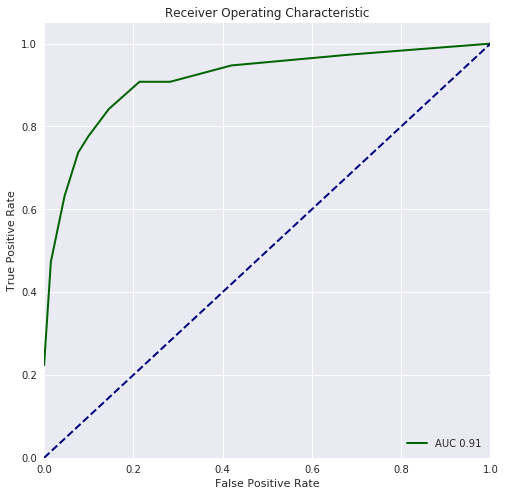

In [236]:
# roc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_roc;
    SELECT madlib.binary_classifier( 
        'public.model_test_scored'
       ,'public.model_test_scored_roc'
       ,'estimated_prob_1'
       ,'approval'
    );
"""
cur.execute(query)

query = """
    SELECT threshold
          ,fpr
          ,tpr
    FROM public.model_test_scored_roc
    ORDER BY 1
"""
df = query_gpdb(query)

# roc curve
pylab.rcParams['figure.figsize'] = (8, 8)

plt.figure()
lw = 2
plt.plot(df['fpr'], df['tpr'], color='darkgreen', lw=lw, label='AUC {:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<a id="rf_confusion_matrix"></a>
#### Confusion Matrix

In [88]:
# confusion matrix (inclusive)
cutoff = 0.5

query = """
        SELECT approval AS obs
              ,CASE WHEN estimated_prob_1 >= {} THEN 1 ELSE 0 END AS pred
              ,count(*) AS num
        FROM public.model_test_scored
        GROUP BY 1,2
        ORDER BY 1,2
    """.format(cutoff)

query_gpdb(query)

,obs,pred,num
0,0,0,107
1,0,1,11
2,1,0,13
3,1,1,76


<a id="rf_plpythonexample"></a>
#### PL/Python Example

In [ ]:
# Train Model


# Score Data


query = """
    SELECT approval
          ,{}
    FROM public.model_inputs
""".format(",".join(featureNames))
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)


from sklearn.ensemble import RandomForestClassifier

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(df[featureNames], df['approval'])

vi = pd.DataFrame({'featureNames':featureNames, 'featureImportance':clf.feature_importances_})

vi.sort_values('featureImportance', ascending=False, inplace=True)
vi

----
## Model Scoring

In [359]:
# drop existing table & run madlib summary stats function
query = """
    DROP TABLE IF EXISTS public.credit_application_summary;
    SELECT madlib.summary('public.credit_application_data','public.credit_application_summary');
    SELECT * FROM public.credit_application_summary;
"""
data_summary = query_gpdb(query)

featureNames = ['a2', 'a3', 'a8', 'a11', 'a14', 'a15', 'a1_a', 'a4_l', 'a4_u', 'a5_g', 'a5_gg', 'a6_aa', 'a6_c', 'a6_cc', 'a6_d', 'a6_e', 'a6_ff', 'a6_i', 'a6_j', 'a6_k', 'a6_m', 'a6_q', 'a6_r', 'a6_w', 'a7_bb', 'a7_dd', 'a7_ff', 'a7_h', 'a7_j', 'a7_n', 'a7_o', 'a7_v', 'a9_true', 'a10_true', 'a12_true', 'a13_g', 'a13_p']
    

def add_continuous_slider(n, default):
    tstr = "target_column == '{}'".format(n)
    minValue = math.floor(data_summary.query(tstr)['min'])
    minValueOrZero = min(0,float(minValue))
    maxValue = math.ceil(data_summary.query(tstr)['max'])
    return widgets.FloatSlider(
        value=default,
        min=minValueOrZero,
        max=maxValue,
        step=0.1,
        description="",
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )

def add_drop_down(n, default):
    
    query = """
        SELECT {} AS col
        FROM public.credit_application_data
        GROUP BY 1
        ORDER BY 1
    """.format(n)
    values = query_gpdb(query)['col']

    return widgets.Dropdown(
        options=values,
        value=default,
        description='',
        disabled=False,
    )

def add_widgets():
    
    message = "### Loan Application \n ------"
    printmd(message)
    
    myWidgets = []

    myWidgets.append({'a1':add_drop_down('a1','a')})
    myWidgets.append({'a2':add_continuous_slider('a2',35.43)})
    myWidgets.append({'a3':add_continuous_slider('a3',12.0)})
    myWidgets.append({'a4':add_drop_down('a4','u')})
    myWidgets.append({'a5':add_drop_down('a5','g')})
    myWidgets.append({'a6':add_drop_down('a6','q')})
    myWidgets.append({'a7':add_drop_down('a7','h')})
    myWidgets.append({'a8':add_continuous_slider('a8',14.0)})
    myWidgets.append({'a9':add_drop_down('a9',True)})
    myWidgets.append({'a10':add_drop_down('a10',True)})
    myWidgets.append({'a11':add_continuous_slider('a11',8.0)})
    myWidgets.append({'a12':add_drop_down('a12',False)})
    myWidgets.append({'a13':add_drop_down('a13','g')})
    myWidgets.append({'a14':add_continuous_slider('a14',0.0)})
    myWidgets.append({'a15':add_continuous_slider('a15',6590.0)})
    
    for widget in myWidgets:
        n = widget.keys()[0]
        printmd("**{}:**".format(n))
        ipd.display(widget[n])

    message = "------"
    printmd(message)
    
    return myWidgets

    
def create_model_input(myWidgets):

    checks = {}
    conts = []
    f = []
    
    for i in range(0,len(featureNames)):
        f.append(0.0)
    
    for feature in featureNames:
        if "_" in feature:
            key = feature[0:feature.find("_")]
            val = feature[feature.find("_")+1:len(feature)]
            if key in checks:
                checks[key].append(val)
            else:
                checks[key] = [val]
        else:
            conts.append(feature)
            
    for widget in myWidgets:
        n = widget.keys()[0]
        val = widget[n].value

        # lower case boolean strings
        if isinstance(val,np.bool_):
            val = str(val).lower()

        if n in checks:
            checkFlag = False
            for c in checks[n]:
                if c == val:
                    checkFlag = True
                    pos = featureNames.index("{}_{}".format(n,val))
                    f[pos] = 1.0   
                    
            # make all associated values 0
            if checkFlag == False:
                for feature in featureNames:
                    if "_" in feature and feature[0:feature.find("_")+1] == n:
                        pos = featureNames.index(feature)
                        f[pos] = 0.0   
        elif n in conts:
            pos = featureNames.index(n)
            f[pos] = val

    return f
        
def rf_score(modelInputs):
    ddlString = "_id integer"
    for f in featureNames:
        ddlString = ddlString + ",{} float".format(f)

    query = """
        DROP TABLE IF EXISTS public.prod_example_data, public.prod_example_score;
        CREATE TABLE public.prod_example_data ({});
        INSERT INTO public.prod_example_data VALUES ({});
        DROP TABLE IF EXISTS public.model_test_scored_tmp;
        SELECT madlib.forest_predict('public.rf_model_output',
                                     'public.prod_example_data',
                                     'public.prod_example_score',
                                     'prob');
        SELECT * FROM public.prod_example_score;
    """.format(ddlString, ",".join(str(x) for x in modelInputs))

    score = float(query_gpdb(query)['estimated_prob_0'])
    
    message = "High"
    if score <= 0.33:
        message = "Low"
    elif score <= 0.66:
        message = "Medium"
    
    return (score, message)
    
def on_appbutton_click(b):
    ipd.clear_output()
    
    message = "### Loan Approval Results \n------\n"
    printmd(message)
    
    modelInput = create_model_input(myWidgets)

    s, m = rf_score(modelInput)
    
    message = "**Approval Score:** {}".format(s)
    printmd(message)
    
    message = "*Your chances of being approved are '{}'*".format(m)
    printmd(message)
    
    printmd("\n------")
    
myWidgets = add_widgets()
appbutton = widgets.Button(description="Calculate Approval")
ipd.display(appbutton)
appbutton.on_click(on_appbutton_click)


### Loan Approval Results 
------


**Approval Score:** 0.3

*Your chances of being approved are 'Low'*


------

In [321]:
"a62_m"[1:"a6_m".find("_")+1]

'62'

In [314]:
"a6"[0:"a6".find("_")]

'a'